In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import torchvision
import random
# from scipy.ndimage.filters import convolve
import cv2

from config import params
from models.mnist_model import Generator, Discriminator, DHead, QHead
from utils import noise_sample

## Load model

In [2]:
# Set random seed for reproducibility.
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

# Use GPU if available.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

Random Seed:  1123
cuda:0  will be used.



In [55]:
model_dir = './checkpoint/'
model_name =  'model_epoch_100_MNIST'
model_path = model_dir + model_name
model = torch.load(model_path)

In [56]:
# Clone models and print architecture
print(model.keys())
netG_weights = model['netG']

dict_keys(['netG', 'discriminator', 'netD', 'netQ', 'optimD', 'optimG', 'params'])


In [57]:
for var_key in list(netG_weights.keys()):
    print(var_key, netG_weights[var_key].shape)

tconv1.weight torch.Size([74, 1024, 1, 1])
bn1.weight torch.Size([1024])
bn1.bias torch.Size([1024])
bn1.running_mean torch.Size([1024])
bn1.running_var torch.Size([1024])
bn1.num_batches_tracked torch.Size([])
tconv2.weight torch.Size([1024, 128, 7, 7])
bn2.weight torch.Size([128])
bn2.bias torch.Size([128])
bn2.running_mean torch.Size([128])
bn2.running_var torch.Size([128])
bn2.num_batches_tracked torch.Size([])
tconv3.weight torch.Size([128, 64, 4, 4])
bn3.weight torch.Size([64])
bn3.bias torch.Size([64])
bn3.running_mean torch.Size([64])
bn3.running_var torch.Size([64])
bn3.num_batches_tracked torch.Size([])
tconv4.weight torch.Size([64, 1, 4, 4])


In [58]:
# Initialize the network
def create_netG(netG_weights):
    netG = Generator().to(device)
    
    netG.tconv1.weight.data = netG_weights['tconv1.weight']
    netG.bn1.weight.data = netG_weights['bn1.weight']
    netG.bn1.bias.data = netG_weights['bn1.bias']
    netG.bn1.running_mean.data = netG_weights['bn1.running_mean']
    netG.bn1.running_var.data = netG_weights['bn1.running_var']
    netG.bn1.num_batches_tracked = netG_weights['bn1.num_batches_tracked']
    
    netG.tconv2.weight.data = netG_weights['tconv2.weight']
    netG.bn2.weight.data = netG_weights['bn2.weight']
    netG.bn2.bias.data = netG_weights['bn2.bias']
    netG.bn2.running_mean.data = netG_weights['bn2.running_mean']
    netG.bn2.running_var.data = netG_weights['bn2.running_var']
    netG.bn2.num_batches_tracked = netG_weights['bn2.num_batches_tracked']
    
    netG.tconv3.weight.data = netG_weights['tconv3.weight']
    netG.bn3.weight.data = netG_weights['bn3.weight']
    netG.bn3.bias.data = netG_weights['bn3.bias']
    netG.bn3.running_mean.data = netG_weights['bn3.running_mean']
    netG.bn3.running_var.data = netG_weights['bn3.running_var']
    netG.bn3.num_batches_tracked = netG_weights['bn3.num_batches_tracked']
    
    netG.tconv4.weight.data = netG_weights['tconv4.weight']
    
    return netG

In [59]:
if (params['dataset'] == 'MNIST'):
    params['num_z'] = 62 # 62
    params['num_dis_c'] = 1 # 1
    params['dis_c_dim'] = 10 # 10
    params['num_con_c'] = 2 # 2
    params['num_dis_label_c'] = 0
    params['num_con_label_c'] = 0
else:
    print('Error: Invalid dataset')

print(params)

{'batch_size': 128, 'num_epochs': 100, 'learning_rate': 0.0002, 'beta1': 0.5, 'beta2': 0.999, 'i_c': 0.5, 'save_epoch': 5, 'dataset': 'MNIST', 'num_z': 62, 'num_dis_c': 1, 'dis_c_dim': 10, 'num_con_c': 2, 'num_dis_label_c': 0, 'num_con_label_c': 0}


In [60]:
netG = create_netG(netG_weights)

## Run the model and save feature maps

In [79]:
def get_intermediate_outputs(latents):
    activations = {}
    
    activations['tconv1'] = netG.tconv1(latents)
    activations['tconv2'] = netG.tconv2(activations['tconv1'])
    activations['tconv3'] = netG.tconv3(activations['tconv2'])
    activations['tconv4'] = netG.tconv4(activations['tconv3'])
    
    return activations

In [62]:
def generate_noise(b_size):
    latents = noise_sample(
        params['num_dis_c'], 
        params['dis_c_dim'], 
        params['num_con_c'], 
        params['num_z'], 
        b_size, device
    )[0]
    if params['num_dis_label_c'] != 0:
        dis_label_c = torch.zeros(b_size, 
                                  params['num_dis_label_c'],
                                  params['dis_c_dim'], 
                                  device=device)
        dis_label_c[np.arange(b_size), 0, real_targets] = 1.0
        dis_label_c = dis_label_c.view(b_size, -1, 1, 1)
        latents = torch.cat((latents, dis_label_c), dim=1)
    
    return latents

#### Sample image

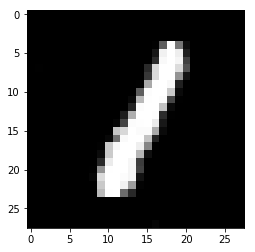

In [220]:
with torch.no_grad():
    latents = generate_noise(100)
    images = netG(latents)
    plt.imshow(images[0][0].detach().cpu(), cmap='gray')

## Display activation maps

In [221]:
def visualize_activation(activation, original, alpha=0.5):
    activation -= activation.min()
    activation *= (1.0 / activation.max())
    resized_activation = cv2.resize(np.float32(activation.detach().cpu()), (original.shape[1], original.shape[2]), interpolation=cv2.INTER_CUBIC)
    overlay = ((1 - alpha) * np.float32(original.detach().cpu()) + alpha * resized_activation)
    return overlay

In [222]:
def plot_images(images, figsize=(10, 10)):
    rows = int(np.ceil(np.sqrt(images.shape[0])))
    cols = images.shape[0] // rows
    figs, axs = plt.subplots(rows, cols, figsize=figsize)
    for i,image in enumerate(images):
        r, c = i % cols, i // cols
        axs[r,c].axis('off')
        axs[r,c].imshow(image.detach().cpu(), cmap='gray')
    plt.show()

def plot_activations(activations, images, figsize=(10,10)):
    rows = int(np.ceil(np.sqrt(images.shape[0])))
    cols = images.shape[0] // rows
    figs, axs = plt.subplots(rows, cols, figsize=figsize)
    for i,image in enumerate(images):
        r, c = i % cols, i // cols
        axs[r,c].axis('off')
        axs[r,c].imshow(visualize_activation(activations[i], image)[0])
    plt.show()

In [223]:
activations = get_intermediate_outputs(latents)

#### 4x4 images

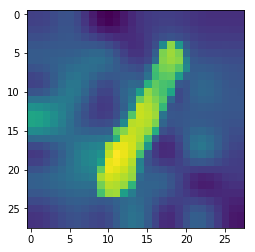

In [224]:
plt.imshow(visualize_activation(activations['tconv2'][0][0], images[0])[0])

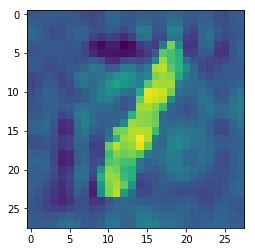

In [225]:
plt.imshow(visualize_activation(activations['tconv3'][0][0], images[0])[0])

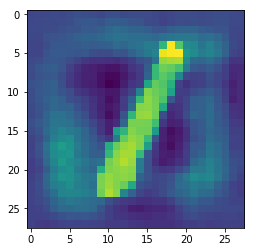

In [226]:
plt.imshow(visualize_activation(activations['tconv4'][0][0], images[0])[0])

## Visualize neurons over many images

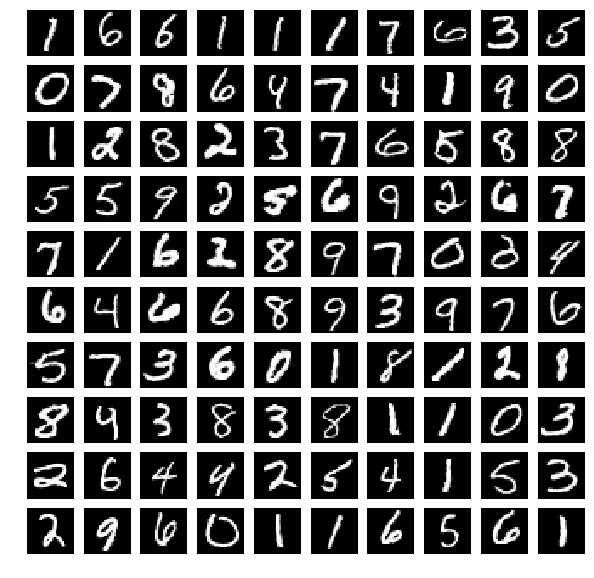

In [228]:
with torch.no_grad():
    latents = generate_noise(100)
    images = netG(latents)
plot_images(images[:,0])

In [204]:
activations = get_intermediate_outputs(latents)

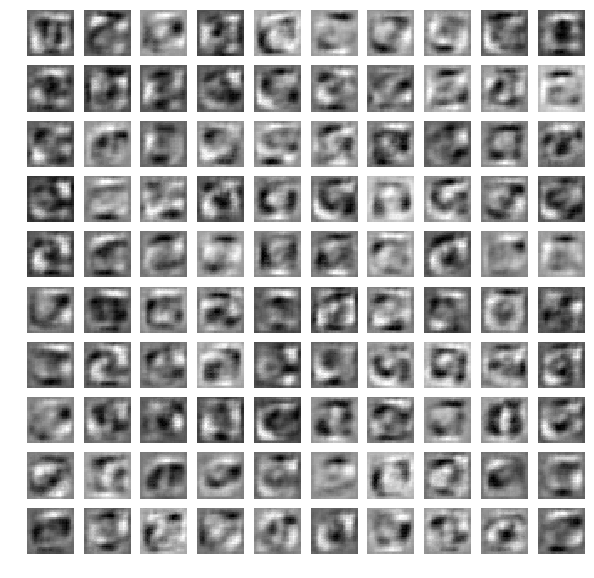

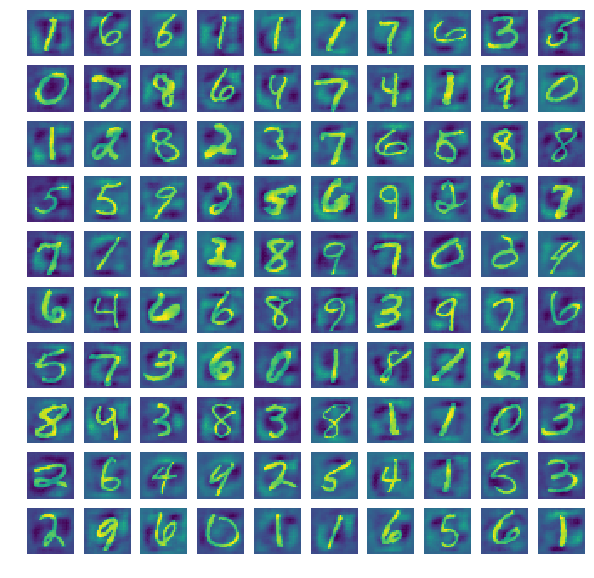

In [230]:
plot_images(activations['tconv4'][:,0])
plot_activations(activations['tconv4'][:,0], images)

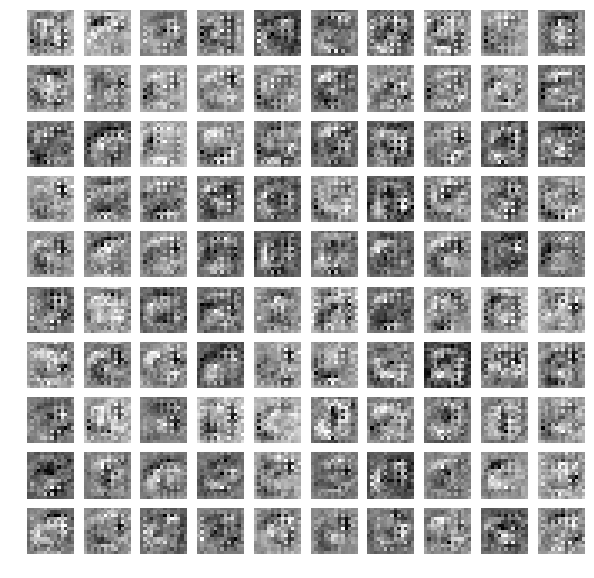

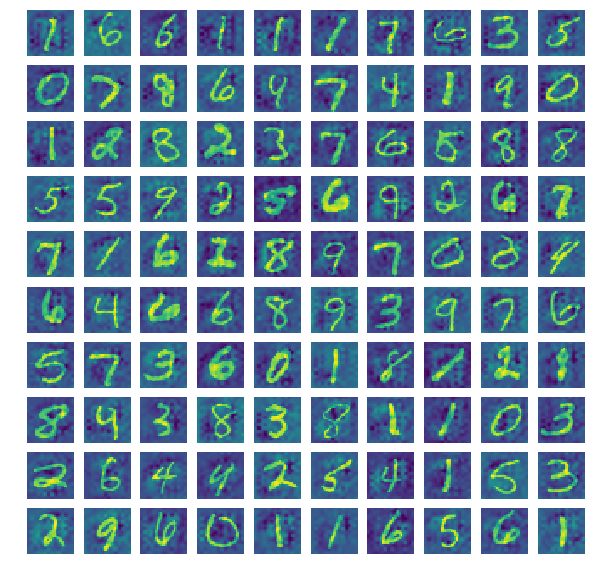

In [242]:
neuron = 20
plot_images(activations['tconv3'][:,neuron])
plot_activations(activations['tconv3'][:,neuron], images)

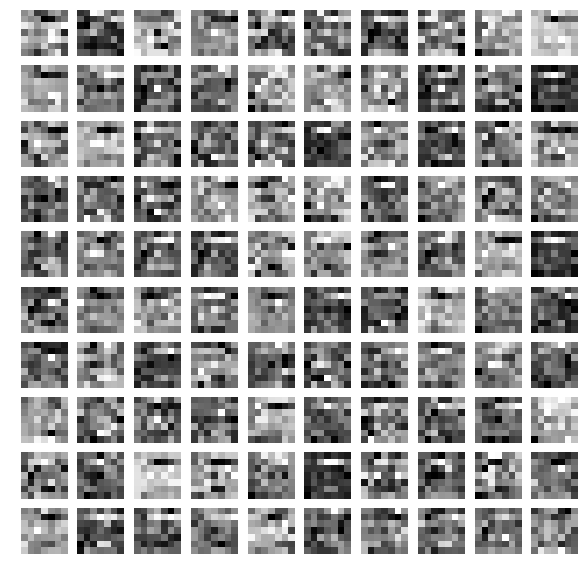

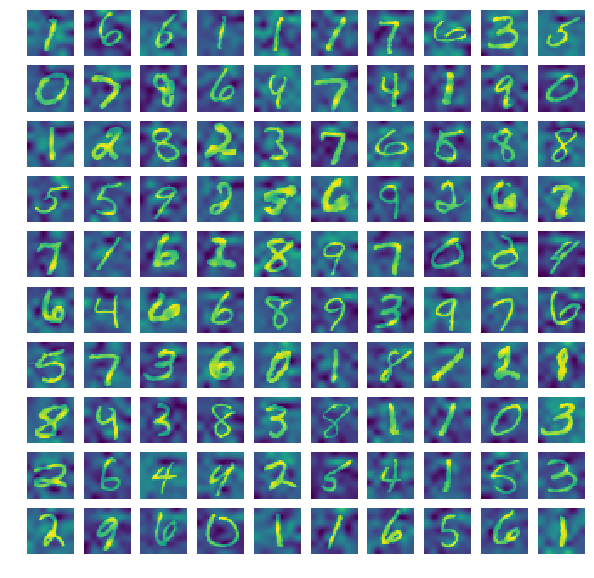

In [241]:
neuron = 15
plot_images(activations['tconv2'][:,neuron])
plot_activations(activations['tconv2'][:,neuron], images)